# Picking the best longitude

I want to treat longitude as the only free parameter to separate our flower observations into two groups: east vs. west

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

# for converting cielab to LCh
from colormath.color_objects import LabColor, LCHabColor
from colormath.color_conversions import convert_color

# for silhouette scores
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')

In [3]:
color_df_reduced = (
    color_df.groupby("gbifID", sort=False, group_keys=False)
    .apply(lambda x: x.sample(1))
    .reset_index(drop=True)
)
color_df_reduced

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_51514/411184798.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,image_idx,hex,rgb,hsl,lab,gbifID,identifier,latitude,longitude
0,0,#d4b4de,"(212, 180, 222)","(0.7936507936507936, 0.38888888888888895, 0.78...","(197, 147, 111)",923911394,https://inaturalist-open-data.s3.amazonaws.com...,48.826305,-102.092171
1,2,#cdb2cb,"(205, 178, 203)","(0.8456790123456791, 0.21259842519685052, 0.75...","(193, 142, 119)",923910407,https://inaturalist-open-data.s3.amazonaws.com...,43.613086,-73.057076
2,4,#bba6d7,"(187, 166, 215)","(0.738095238095238, 0.3798449612403101, 0.7470...","(182, 145, 106)",899970365,https://inaturalist-open-data.s3.amazonaws.com...,43.066871,-87.890565
3,7,#9984ae,"(153, 132, 174)","(0.75, 0.2058823529411765, 0.6000000000000001)","(149, 144, 109)",891778924,https://inaturalist-open-data.s3.amazonaws.com...,42.140556,-87.831643
4,9,#ba9edb,"(186, 158, 219)","(0.7431693989071038, 0.4586466165413533, 0.739...","(177, 150, 101)",891760719,https://inaturalist-open-data.s3.amazonaws.com...,38.679240,-97.990035
...,...,...,...,...,...,...,...,...,...
16582,41059,#9f8fc0,"(159, 143, 192)","(0.7210884353741497, 0.27999999999999997, 0.65...","(159, 144, 105)",1024218211,https://inaturalist-open-data.s3.amazonaws.com...,41.569419,-88.150552
16583,41060,#b47eb0,"(180, 126, 176)","(0.845679012345679, 0.2647058823529413, 0.6000...","(152, 157, 110)",1024202810,https://inaturalist-open-data.s3.amazonaws.com...,45.057871,-87.168277
16584,41061,#ae95c8,"(174, 149, 200)","(0.7483660130718954, 0.31677018633540366, 0.68...","(167, 147, 105)",1024200169,https://inaturalist-open-data.s3.amazonaws.com...,42.921738,-88.026752
16585,41063,#c8b9b1,"(200, 185, 177)","(0.057971014492753624, 0.17293233082706772, 0....","(194, 132, 134)",1024198670,https://inaturalist-open-data.s3.amazonaws.com...,40.791723,-80.492498


#### split Lab into separate components and get it into the "literal" metric rather than the opencv default of 0-255

In [4]:
L = [(int(i.strip('()').split(', ')[0])) for i in color_df_reduced.lab]
L = (np.array(L) / 255.0) * 100.0  
color_df_reduced['L'] = L
a = [(int(i.strip('()').split(', ')[1])) for i in color_df_reduced.lab]
a = np.array(a) - 128.0  
color_df_reduced['a'] = a
b = [(int(i.strip('()').split(', ')[2])) for i in color_df_reduced.lab]
b = np.array(b) - 128.0
color_df_reduced['b'] = b

### try silhouette index for evaluating clusters?

e.g.: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [5]:
# figured we'd start with a function that we cna pick up
def longitude_split_silhouette(df,
                         lon_col='longitude',
                         color_cols=('L','a','b'),
                         n_grid=300,
                         min_prop=0.01
                              ):
    lons = []
    scores = []
    # standardize the scores... bc L has a different range
    X = StandardScaler().fit_transform(df[list(color_cols)].values)

    # evenly spaced lons
    grid = np.linspace(df[lon_col].min(), df[lon_col].max(), n_grid)

    best_lon, best_score = None, -np.inf
    for curr_lon in grid:
        labels = (df[lon_col] >= curr_lon).astype(int)
        # skip if we don't have enough in one
        p = labels.mean()
        if p < min_prop or p > 1 - min_prop:
            continue
        score = silhouette_score(X, labels)
        lons.append(curr_lon)
        scores.append(score)
        if score > best_score:
            best_score, best_lon = score, curr_lon

    return [[lons,scores],[best_lon, best_score]]

In [6]:
(color_df_reduced.longitude.max()-color_df_reduced.longitude.min()) / 300

np.float64(0.24624947)

In [7]:
all_results, best_vals = longitude_split_silhouette(color_df_reduced,n_grid=300)

In [8]:
best_vals

[np.float64(-103.68299100668898), np.float64(0.2819486223000439)]

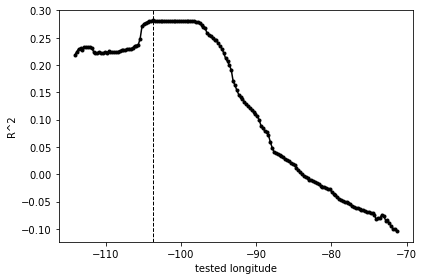

In [9]:
plt.plot(np.array(all_results[0]), np.array(all_results[1]), marker='o', ms=3,c='black')
plt.axvline(best_vals[0], ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()

# Re-do on LCh values

In [10]:
lab_vals = np.array(color_df_reduced[['L','a','b']])

lch_arr = np.empty_like(lab_vals)
for i, (L_, a_, b_) in enumerate(lab_vals):
    # had to think carefully here -- these look like the correct defaults
    # rather than d50 illuminant because of I used opencv at its default
    lab = LabColor(L_, a_, b_, observer='2', illuminant='d65') 
    lch = convert_color(lab, LCHabColor)
    lch_arr[i] = lch.get_value_tuple()

In [11]:
color_df_reduced['lch_l'] = lch_arr[:,0]
color_df_reduced['lch_c'] = lch_arr[:,1]
color_df_reduced['lch_h'] = lch_arr[:,2]

In [12]:
all_results, best_vals = longitude_split_silhouette(color_df_reduced,color_cols=('lch_l','lch_c','lch_h'),n_grid=300)

In [13]:
best_vals

[np.float64(-98.74153007023412), np.float64(0.24188774374954408)]

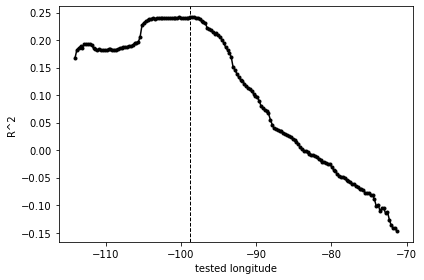

In [14]:
plt.plot(np.array(all_results[0]), np.array(all_results[1]), marker='o', ms=3,c='black')
plt.axvline(best_vals[0], ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()

# Mostly a big plateau with the silhouette approach.

# Sums-of-squares / anova approach

### cielab values

In [15]:
r2s = []
lons = []
for focal_lon in np.linspace(color_df_reduced.longitude.min()+1, color_df_reduced.longitude.max()-1,300):
    west  = color_df_reduced.longitude < focal_lon
    east  = ~west
    X     = color_df_reduced[['L','a','b']].to_numpy().astype(float)
    
    # overall mean from full data... three vals
    mu = X.mean(axis=0)

    # total sum of squares (dist of all observations from mean, squared)
    SST = np.sum((X - mu)**2)
    
    # mean of each region.. three vals each
    mu_w = X[west].mean(axis=0)
    mu_e = X[east].mean(axis=0)

    # between-group sum of squares....
    
    # count number of points in each region
    n_w = west.sum()
    n_e = east.sum()

    ssb_w = n_w * np.sum((mu_w - mu)**2)
    ssb_e = n_e * np.sum((mu_e - mu)**2)
    SSB    = ssb_w + ssb_e # overall between
    # SSB here gives us how far each group mean is from the overall mean
    # and multiplying weights by group size

    # proportion of variance explained by ssb, this is eta-squared
    R2 = SSB / SST
    
    r2s.append(R2)
    lons.append(focal_lon)
    # print out both
    #print(f"R^2 = {R2:.3f}, Lon = {focal_lon: .3f}")

In [16]:
best_lon = lons[np.argmax(r2s)]
best_lon

np.float64(-97.76996029096992)

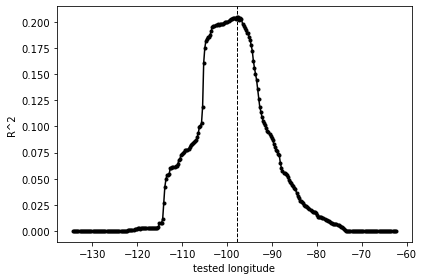

In [17]:
plt.plot(lons, r2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()

#### Redo with LCh values

In [18]:
r2s = []
lons = []
for focal_lon in np.linspace(color_df_reduced.longitude.min()+1, color_df_reduced.longitude.max()-1,300):
    west  = color_df_reduced.longitude < focal_lon
    east  = ~west
    X     = color_df_reduced[['lch_l','lch_c','lch_h']].to_numpy().astype(float)
    
    # overall mean from full data... three vals
    mu = X.mean(axis=0)

    # total sum of squares (dist of all observations from mean, squared)
    SST = np.sum((X - mu)**2)
    
    # mean of each region.. three vals each
    mu_w = X[west].mean(axis=0)
    mu_e = X[east].mean(axis=0)

    # between-group sum of squares....
    
    # count number of points in each region
    n_w = west.sum()
    n_e = east.sum()

    ssb_w = n_w * np.sum((mu_w - mu)**2)
    ssb_e = n_e * np.sum((mu_e - mu)**2)
    SSB    = ssb_w + ssb_e # overall between
    # SSB here gives us how far each group mean is from the overall mean
    # and multiplying weights by group size

    # proportion of variance explained by ssb, this is eta-squared
    R2 = SSB / SST
    
    r2s.append(R2)
    lons.append(focal_lon)
    # print out both
    #print(f"R^2 = {R2:.3f}, Lon = {focal_lon: .3f}")

In [19]:
best_lon = lons[np.argmax(r2s)]
best_lon

np.float64(-97.04880804013379)

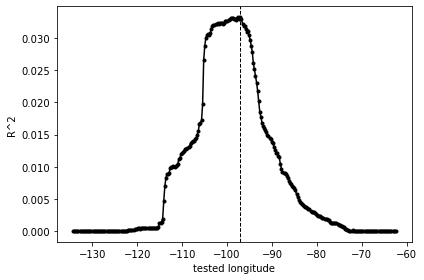

In [20]:
plt.plot(lons, r2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()

# More of a peak here. I'll filter outliers just in case:

In [21]:
color_df_reduced_filter = color_df_reduced[color_df_reduced.lch_h > 250]

In [22]:
r2s = []
lons = []
for focal_lon in np.linspace(color_df_reduced_filter.longitude.min()+1, color_df_reduced_filter.longitude.max()-1,300):
    west  = color_df_reduced_filter.longitude < focal_lon
    east  = ~west
    X     = color_df_reduced_filter[['lch_l','lch_c','lch_h']].to_numpy().astype(float)
    
    # overall mean from full data... three vals
    mu = X.mean(axis=0)

    # total sum of squares (dist of all observations from mean, squared)
    SST = np.sum((X - mu)**2)
    
    # mean of each region.. three vals each
    mu_w = X[west].mean(axis=0)
    mu_e = X[east].mean(axis=0)

    # between-group sum of squares....
    
    # count number of points in each region
    n_w = west.sum()
    n_e = east.sum()

    ssb_w = n_w * np.sum((mu_w - mu)**2)
    ssb_e = n_e * np.sum((mu_e - mu)**2)
    SSB    = ssb_w + ssb_e
    # SSB here gives us how far each group mean is from the overall mean
    # and multiplying weights by group size

    # proportion of variance explained by ssb
    R2 = SSB / SST
    
    r2s.append(R2)
    lons.append(focal_lon)
    # print out both
    #print(f"R^2 = {R2:.3f}, Lon = {focal_lon: .3f}")

In [23]:
best_lon = lons[np.argmax(r2s)]
best_lon

np.float64(-97.76996029096992)

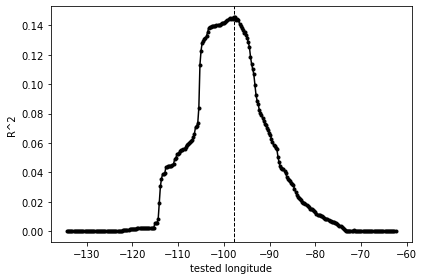

In [24]:
plt.plot(lons, r2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()

# What does this look like if we scramble colors between regions? ...making sure we're picking up on actual signal...

In [25]:
scramble_df = color_df_reduced_filter.copy()

In [26]:
lch_sub = scramble_df[['L','a','b']]

In [27]:
scramble_sub = lch_sub.sample(len(lch_sub)).to_numpy()

In [28]:
scramble_df[['L','a','b']] = scramble_sub

In [29]:
r2s = []
lons = []
for focal_lon in np.linspace(scramble_df.longitude.min()+1, scramble_df.longitude.max()-1,300):
    west  = scramble_df.longitude < focal_lon
    east  = ~west
    X     = scramble_df[['L','a','b']].to_numpy().astype(float)
    
    # overall mean from full data... three vals
    mu = X.mean(axis=0)

    # total sum of squares (dist of all observations from mean, squared)
    SST = np.sum((X - mu)**2)
    
    # mean of each region.. three vals each
    mu_w = X[west].mean(axis=0)
    mu_e = X[east].mean(axis=0)

    # between-group sum of squares....
    
    # count number of points in each region
    n_w = west.sum()
    n_e = east.sum()

    ssb_w = n_w * np.sum((mu_w - mu)**2)
    ssb_e = n_e * np.sum((mu_e - mu)**2)
    SSB    = ssb_w + ssb_e
    # SSB here gives us how far each group mean is from the overall mean
    # and multiplying weights by group size

    # proportion of variance explained by ssb
    R2 = SSB / SST
    
    r2s.append(R2)
    lons.append(focal_lon)
    # print out both
    #print(f"R^2 = {R2:.3f}, Lon = {focal_lon: .3f}")

In [30]:
best_lon = lons[np.argmax(r2s)]
best_lon

np.float64(-63.63542041806021)

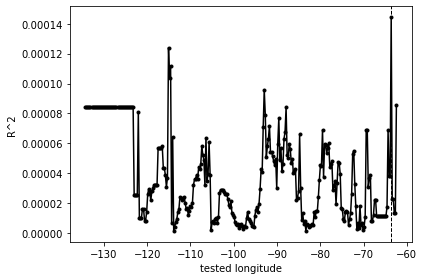

In [31]:
plt.plot(lons, r2s, marker='o', ms=3,c='black')
plt.axvline(best_lon, ls='--', lw=1, color='k')
plt.xlabel('tested longitude')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()